# Avaliação da Rede

In [1]:
import tensorflow as tf
import keras as kr
import numpy as np
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
from keras.models import load_model
#Para referência
#Image Super-Resolution Using Deep Convolutional Networks by Dong et al - 2015
def DongCNN(in_shape):
    model = Sequential()
    
    model.add(Conv2D(64, (9, 9), padding='same', input_shape=in_shape))
    model.add(Activation("relu"))
    model.add(Conv2D(32, (5, 5), padding='same'))
    model.add(Activation("relu"))
    model.add(Conv2D(1, (5,5), padding='same'))
    
    return model


net = load_model("DongSISR_black")

Vamos visualizar alguns exemplos em patches

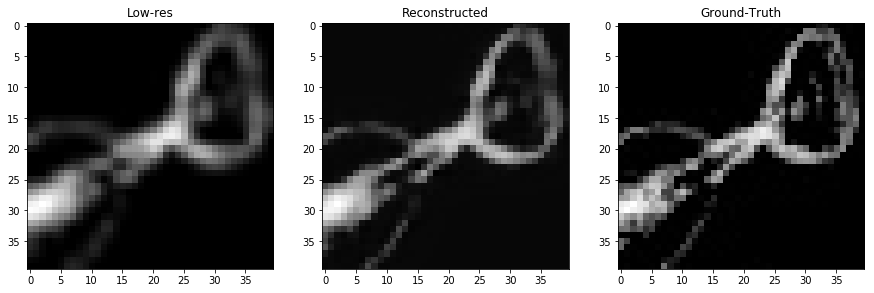

In [5]:
dataset = np.load("dataset_black.npy")
X = dataset[:,1,:,:]
y = dataset[:,0,:,:]

ex = 10234
patch = X[ex]
truth = y[ex]
preds = net.predict(patch.reshape((1,) + patch.shape + (1,)))[0]

patch = patch.reshape(patch.shape[0:2])
truth = truth.reshape(truth.shape[0:2])
preds = preds.reshape(preds.shape[0:2])


fig = plt.figure(figsize=(15,15))
fig.add_subplot("131")
plt.title("Low-res")
plt.imshow(patch, cmap='gray')

fig.add_subplot("132")
plt.title("Reconstructed")
plt.imshow(preds, cmap='gray')

fig.add_subplot("133")
plt.title("Ground-Truth")
plt.imshow(truth, cmap='gray')

Agora com uma imagem inteira

In [13]:
from skimage.transform import rescale as rescale
from scipy.misc import imresize as imresize
from skimage.util import invert

test_image = plt.imread("10023.jpg")
test_image = invert(test_image)
smol = rescale(test_image, 0.5, anti_aliasing=True, multichannel=False, mode='reflect')
baseline = imresize(smol, (94, 104), interp="bicubic") #baseline do artigo é interpolação bicubic 

/home/abello/miniconda3/envs/deeplabv3/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [14]:
import itertools

output = np.zeros(baseline.shape)
overlap = np.zeros(baseline.shape)

for y, x in itertools.product(range(0, smol.shape[0] - 19), range(0, smol.shape[1] - 19)):
    predpatch = smol[y:y + 20, x: x + 20]
    predpatch = imresize(predpatch, (40, 40), interp='bicubic')
    predpatch = net.predict(predpatch.reshape((1,) + predpatch.shape + (1,)))[0]
    predpatch = predpatch.reshape(predpatch.shape[0:2])
    output[y * 2: y * 2 + 40, x * 2: x * 2 + 40] += predpatch
    overlap[y * 2: y * 2 + 40, x * 2: x * 2 + 40] += 1

output = output / overlap

/home/abello/miniconda3/envs/deeplabv3/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


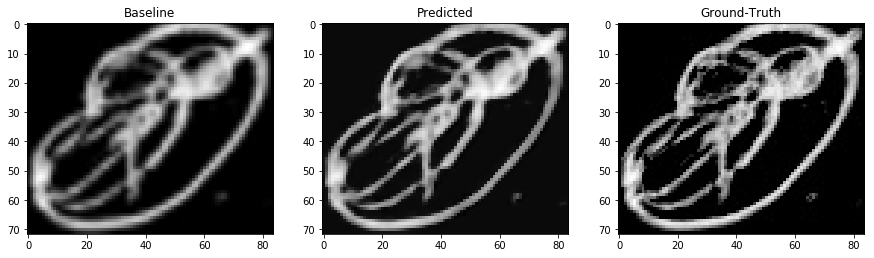

In [30]:
fig = plt.figure(figsize=(15,15))
fig.add_subplot("131")
plt.title("Baseline")
plt.imshow(baseline[12:84,10:94], cmap='gray')

fig.add_subplot("132")
plt.title("Predicted")
plt.imshow(output[12:84,10:94], cmap='gray')

fig.add_subplot("133")
plt.title("Ground-Truth")
plt.imshow(test_image[12:84,10:94], cmap='gray')

No entanto, numéricamente a nossa solução ainda é (bem) inferior:

In [31]:
#mse de duas matrizes
def mse(y, x):
    return np.sum((y - x) ** 2) / np.prod(y.shape)

print("MSE baseline: ", mse(baseline[12:84,10:94], test_image[12:84,10:94]))
print("MSE predição: ", mse(output[12:84,10:94], test_image[12:84,10:94]))

MSE baseline:  55.47189153439153
MSE predição:  352.81927265835986


(94, 104)

## Hipóteses / Testes

* Mínimo local: estratégia de cinza diminui MSE no dataset inteiro, mas não nas imagens
* Inverter imagem ajudaria pois o fundo equivaleria a 0 e seria mais facilmente ignorado (dado a natureza das operações)

## Próximos Passos

* Implementar outras métricas (PSNR e SSIM)
* Testar Arquiteturas
* Implementar outras funções de perda (VGG19 'perceptual' e GAN)